In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from ftplib import FTP
from calendar import isleap
from collections import defaultdict
import pickle

#Stations that do not go all the way to Dec 2017 for tmax
#USC00117551_tmax, USC00116910_tmax, USC00111280_tmax, USC00118147_tmax, USC00115515_tmax

In [0]:
#weather stations to download .dly files from

#USC00118916, USC00113335, USC00117551, USC00116910, USC00118740, USC00111280, USC00111436, USC00118147, USC00115515

colspecs = ((0,12),(12,21),(21,31),(31,38),
	    (38,41),(41,72),(72,80),(80,86))
meta = pd.read_fwf('ghcnd-stations.txt',
		    colspecs=colspecs,header=None,index_col=False,
		    names=['stationID','lat','lon','elev',
			   'state','name','network','val'])
		   
ushcn = meta[meta['network'].str.match('HCN',na=False)]

states = ['IL']

stations = ushcn[ushcn.state.isin(states)].stationID.values.tolist()

# save location information for later
loc_var = ['lat','lon','elev']
tmp = ushcn.loc[ushcn.stationID.isin(stations),loc_var]
locs = pd.DataFrame(data=tmp.values,index=stations,columns=loc_var).T

stations = [s+'.dly' for s in stations]

ftp = FTP('ftp.ncdc.noaa.gov')
# email address should work for password
ftp.login(passwd='XXX@YYY')
ftp.cwd('/pub/data/ghcn/daily/hcn')
# make sure you're in the right directory

stat = 'USC00115515.dly'
ftp.retrbinary('RETR '+stat, open(stat,'wb').write)
if int(stat[3:11]) % 5 == 0: print(stat)
ftp.close()

In [0]:
IL_counties = pd.read_csv('Grouped_IL_Counties.csv')
IL_counties.head()

,COUNTY_NAM,CO_FIPS,STATION_ID
0,MCHENRY,111,USC00118916
1,BOONE,7,USC00118916
2,OGLE,141,USC00118916
3,LASALLE,99,USC00118916
4,BUREAU,11,USC00118916


In [0]:
def var_ext(var,stat):
  sv = pd.Series()
  
  # index of variable to extract
  idx = stat[stat.loc[:,'VAR']==var].index.tolist()
  
  # days in each month incl. leap year day
  days = [31,28,31,30,31,30,31,31,30,31,30,31]
  ldays = [31,29,31,30,31,30,31,31,30,31,30,31]
  
  # convenience variables for years and months
  yr = stat.loc[idx,'YR']
  mo = stat.loc[idx,'MO']
  
  # loop through every instance of the variable to extract
  for i in idx:
    # number of days in month
    if isleap(yr[i]):
      d = ldays[mo[i]-1]
    else:
      d = days[mo[i]-1]
    # only pull values that correspond to days in the month
    out = stat.loc[i][list(range(4,4*(d+1),4))] 
    
    # replace missing values with NaN
    out[out==-9999] = np.nan
    
    # reindex with proper time stamp
    tm = pd.to_datetime({'year':yr[i],'month':mo[i],'day':range(1,d+1)})
    out = pd.Series(out.values,index=tm)*0.1 # convert to measured units
    sv = pd.concat([sv,out])
    
  # get full date vector and expand NaNs for missing data
  date1 = pd.to_datetime({'year':yr[idx[0]],'month':mo[idx[0]],'day':[1]})
  date2 = pd.to_datetime({'year':yr[idx[-1]],'month':mo[idx[-1]],'day':[d]})
  all_dates = pd.date_range(start=date1[0],end=date2[0])
  sv = sv.reindex(index=all_dates)
  return sv

In [0]:
#Make dictionaries storing tmax and tmin data for each station. Takes a few minutes!

wids = [11,4,2,4]+[5,1,1,1]*31
nam = ['VAL','MFL','QFL','SFL']*31
num = list(range(1,32))*4
num.sort()
val_flg = [nam[i]+str(num[i]) for i in range(len(num))]

stations = ['USC00118916.dly', 'USC00113335.dly', 'USC00117551.dly', 'USC00116910.dly', 'USC00118740.dly', 'USC00111280.dly', 'USC00111436.dly', 'USC00118147.dly', 'USC00115515.dly']

tmax_dict = {}
for s in stations:
  stat = pd.read_fwf(s,widths=wids,header=None,index_col=False,names=['ID','YR','MO','VAR']+val_flg)
  tmax = var_ext('TMAX', stat)
  s = s.replace('.dly', '')
  tmax_dict[s] = tmax
  
tmin_dict = {}
for s in stations:
  stat = pd.read_fwf(s,widths=wids,header=None,index_col=False,names=['ID','YR','MO','VAR']+val_flg)
  tmax = var_ext('TMIN', stat)
  s = s.replace('.dly', '')
  tmin_dict[s] = tmax

In [0]:
#Combine tmax and tmin for each station

combined_dict = {}

for i,j in tmax_dict.items():
  df = pd.concat([tmax_dict[i].rename('TMAX'), tmin_dict[i].rename('TMIN')], axis=1)
  combined_dict[i] = df
  

In [0]:
#Save raw temp data using pickle
pickle.dump(combined_dict, open('raw_temp_data.p', 'wb'))

In [0]:
combined_dict.keys()

In [0]:
#Original version of interpolate code. Made modification to deal with very last value being nan

# interpolated_TMAX_dict = {}
# bad_years_TMAX_dict = {}

# for i, j in combined_dict.items():
  
#   #Pick out ith df. Make sure index is in datetime. Set date range. Make a copy of TMAX column in df
#   temp_sample = copy.deepcopy(combined_dict[i].loc['1981-01-01':'2017-12-31']) 
#   temp_TMAX = copy.deepcopy(temp_sample[['TMAX']])
#   temp_TMAX['TMAX'] = pd.to_numeric(temp_TMAX['TMAX'])

#   count = 0
#   flag = False
#   bad_years_TMAX = []

#   #idx is the row number starting at zero, t is the actual temperature value
#   for idx, t in enumerate(temp_TMAX.TMAX):
#     if flag == False and ~np.isnan(t):
#       continue

#     elif flag == False and np.isnan(t):
#       #Case where row 0 is nan. Make value of row 1 = row 2, then set start index to row 0
#       if idx == 0:
#         flag = False
#         temp_TMAX.iloc[0] = temp_TMAX.iloc[1].values

#       elif idx != 0:
#         flag = True
#         start_index = temp_TMAX.index[idx-1] #find index of point right before first nan
#         count = count + 1

#     elif flag == True and np.isnan(t):
#       count = count + 1

#     elif flag == True and ~np.isnan(t):
#       flag == False
#       end_index = temp_TMAX.index[idx]

#       if count <= 7:
#         interpolated = temp_TMAX[start_index:end_index].interpolate()
#         temp_TMAX.update(interpolated) #update the uninterpolated data with the newly interpolated data


#       elif count > 7:
#         if end_index.year not in bad_years_TMAX:
#           bad_years_TMAX.append(end_index.year)

#           if start_index.year not in bad_years_TMAX: #in case missing data stretches between years
#             bad_years_TMAX.append(start_index.year)

#       count = 0

#   #add a years column
#   temp_TMAX['year'] = temp_TMAX.index.year  

#   #drop the rows in bad years
#   for b in bad_years_TMAX:
#     temp_TMAX = temp_TMAX[temp_TMAX.index.year != b]

#   #drop the year column
#   temp_TMAX = temp_TMAX.drop(columns = ['year'])

#   interpolated_TMAX_dict[i] = temp_TMAX
#   bad_years_TMAX_dict[i] = bad_years_TMAX

In [0]:
# interpolated_TMIN_dict = {}
# bad_years_TMIN_dict = {}

# for i, j in combined_dict.items():
  
#   #Pick out ith df. Make sure index is in datetime. Set date range. Make a copy of TMAX column in df
#   temp_sample = copy.deepcopy(combined_dict[i].loc['1981-01-01':'2017-12-31']) 
#   temp_TMIN = copy.deepcopy(temp_sample[['TMIN']])
#   temp_TMIN['TMIN'] = pd.to_numeric(temp_TMIN['TMIN'])

#   count = 0
#   flag = False
#   bad_years_TMIN = []

#   #idx is the row number starting at zero, t is the actual temperature value
#   for idx, t in enumerate(temp_TMIN.TMIN):
#     if flag == False and ~np.isnan(t):
#       continue

#     elif flag == False and np.isnan(t):
#       #Case where row 0 is nan. Make value of row 1 = row 2, then set start index to row 0
#       if idx == 0:
#         flag = False
#         temp_TMIN.iloc[0] = temp_TMIN.iloc[1].values

#       elif idx != 0:
#         flag = True
#         start_index = temp_TMIN.index[idx-1] #find index of point right before first nan
#         count = count + 1

#     elif flag == True and np.isnan(t):
#       count = count + 1

#     elif flag == True and ~np.isnan(t):
#       flag == False
#       end_index = temp_TMIN.index[idx]

#       if count <= 7:
#         interpolated = temp_TMIN[start_index:end_index].interpolate()
#         temp_TMIN.update(interpolated) #update the uninterpolated data with the newly interpolated data


#       elif count > 7:
#         if end_index.year not in bad_years_TMIN:
#           bad_years_TMIN.append(end_index.year)

#           if start_index.year not in bad_years_TMIN: #in case missing data stretches between years
#             bad_years_TMIN.append(start_index.year)

#       count = 0

#   #add a years column
#   temp_TMIN['year'] = temp_TMIN.index.year  

#   #drop the rows in bad years
#   for b in bad_years_TMIN:
#     temp_TMIN = temp_TMIN[temp_TMIN.index.year != b]

#   #drop the year column
#   temp_TMIN = temp_TMIN.drop(columns = ['year'])

#   interpolated_TMIN_dict[i] = temp_TMIN
#   bad_years_TMIN_dict[i] = bad_years_TMIN

In [0]:
interpolated_TMAX_dict = {}
bad_years_TMAX_dict = {}

for i, j in combined_dict.items():
  
  #Pick out ith df. Make sure index is in datetime. Set date range. Make a copy of TMAX column in df
  temp_sample = copy.deepcopy(combined_dict[i].loc['1981-01-01':'2017-12-31']) 
  temp_TMAX = copy.deepcopy(temp_sample[['TMAX']])
  temp_TMAX['TMAX'] = pd.to_numeric(temp_TMAX['TMAX'])

  count = 0
  flag = False
  bad_years_TMAX = []

  #idx is the row number starting at zero, t is the actual temperature value
  for idx, t in enumerate(temp_TMAX.TMAX):
    if flag == False and ~np.isnan(t):
      continue

    elif flag == False and np.isnan(t):
      #Case where row 0 is nan. Make value of row 1 = row 2, then set start index to row 0
      if idx == 0:
        flag = False
        temp_TMAX.iloc[0] = temp_TMAX.iloc[1].values

      elif idx != 0:
        flag = True
        start_index = temp_TMAX.index[idx-1] #find index of point right before first nan
        count = count + 1

    elif flag == True and np.isnan(t):
      count = count + 1
      if count > 7 and len(temp_TMAX)-1 == idx:
        bad_years_TMAX.append(temp_TMAX.index[idx].year)

    elif flag == True and ~np.isnan(t):
      flag == False
      end_index = temp_TMAX.index[idx]

      if count <= 7:
        interpolated = temp_TMAX[start_index:end_index].interpolate()
        temp_TMAX.update(interpolated) #update the uninterpolated data with the newly interpolated data


      elif count > 7:
        if end_index.year not in bad_years_TMAX:
          bad_years_TMAX.append(end_index.year)

          if start_index.year not in bad_years_TMAX: #in case missing data stretches between years
            bad_years_TMAX.append(start_index.year)

      count = 0

  #add a years column
  temp_TMAX['year'] = temp_TMAX.index.year  

  #drop the rows in bad years
  for b in bad_years_TMAX:
    temp_TMAX = temp_TMAX[temp_TMAX.index.year != b]

  #drop the year column
  temp_TMAX = temp_TMAX.drop(columns = ['year'])

  interpolated_TMAX_dict[i] = temp_TMAX
  bad_years_TMAX_dict[i] = bad_years_TMAX

In [0]:
interpolated_TMIN_dict = {}
bad_years_TMIN_dict = {}

for i, j in combined_dict.items():
  
  #Pick out ith df. Make sure index is in datetime. Set date range. Make a copy of TMAX column in df
  temp_sample = copy.deepcopy(combined_dict[i].loc['1981-01-01':'2017-12-31']) 
  temp_TMIN = copy.deepcopy(temp_sample[['TMIN']])
  temp_TMIN['TMIN'] = pd.to_numeric(temp_TMIN['TMIN'])

  count = 0
  flag = False
  bad_years_TMIN = []

  #idx is the row number starting at zero, t is the actual temperature value
  for idx, t in enumerate(temp_TMIN.TMIN):
    if flag == False and ~np.isnan(t):
      continue

    elif flag == False and np.isnan(t):
      #Case where row 0 is nan. Make value of row 1 = row 2, then set start index to row 0
      if idx == 0:
        flag = False
        temp_TMIN.iloc[0] = temp_TMIN.iloc[1].values

      elif idx != 0:
        flag = True
        start_index = temp_TMIN.index[idx-1] #find index of point right before first nan
        count = count + 1

    elif flag == True and np.isnan(t):
      count = count + 1
      #Case where very last value in dataset is nan so end index never found
      if count > 7 and len(temp_TMIN)-1 == idx:
        bad_years_TMIN.append(temp_TMIN.index[idx].year)

    elif flag == True and ~np.isnan(t):
      flag == False
      end_index = temp_TMIN.index[idx]

      if count <= 7:
        interpolated = temp_TMIN[start_index:end_index].interpolate()
        temp_TMIN.update(interpolated) #update the uninterpolated data with the newly interpolated data


      elif count > 7:
        if end_index.year not in bad_years_TMIN:
          bad_years_TMIN.append(end_index.year)

          if start_index.year not in bad_years_TMIN: #in case missing data stretches between years
            bad_years_TMIN.append(start_index.year)

      count = 0

  #add a years column
  temp_TMIN['year'] = temp_TMIN.index.year  

  #drop the rows in bad years
  for b in bad_years_TMIN:
    temp_TMIN = temp_TMIN[temp_TMIN.index.year != b]

  #drop the year column
  temp_TMIN = temp_TMIN.drop(columns = ['year'])

  interpolated_TMIN_dict[i] = temp_TMIN
  bad_years_TMIN_dict[i] = bad_years_TMIN

In [0]:
#Recombine TMIN and TMAX

combined_dict = {}

for i,j in interpolated_TMAX_dict.items():
  df = pd.concat([interpolated_TMAX_dict[i], interpolated_TMIN_dict[i]], axis=1)
  combined_dict[i] = df

In [0]:
#Merge bad years lists
bad_years = defaultdict(list)

for d in (bad_years_TMIN_dict, bad_years_TMAX_dict):
  for key, value in d.items():
    bad_years[key].append(value)
    
for i, j in bad_years.items():
  bad_years[i] = list(set(bad_years[i][0] + bad_years[i][1]))

#Make sure all bad years are removed from relevant station
for i in combined_dict:
  for b in bad_years[i]:
    combined_dict[i] = combined_dict[i][combined_dict[i].index.year != b]

In [0]:
for i in combined_dict:

  #Make columns for bounded temps. For now just copy observed values into them.
  combined_dict[i]['TMAX_bound'] = combined_dict[i]['TMAX']
  combined_dict[i]['TMIN_bound'] = combined_dict[i]['TMIN']
  
  #Constrain the TMAX and TMIN values
  combined_dict[i].loc[combined_dict[i].TMAX_bound >= 29, 'TMAX_bound'] = 29
  combined_dict[i].loc[combined_dict[i].TMAX_bound <= 9, 'TMAX_bound'] = 9
  
  combined_dict[i].loc[combined_dict[i].TMIN_bound >= 29, 'TMIN_bound'] = 29
  combined_dict[i].loc[combined_dict[i].TMIN_bound <= 9, 'TMIN_bound'] = 9
  
  #Make new column for GDD
  combined_dict[i]['GDD'] = (((combined_dict[i].TMIN_bound) + (combined_dict[i].TMAX_bound))/2) - 9
  
  #Make new column for KDD. np.where(condition, value if true, value if false)
  combined_dict[i]['KDD'] = np.where(combined_dict[i].TMAX > 29, combined_dict[i].TMAX - 29, 0)
  
  
  

In [0]:
#Stop here for tonight. 
combined_dict['USC00111280'].loc['1981-04-20':'1981-04-30']

,TMAX,TMIN,TMAX_bound,TMIN_bound,GDD,KDD
1981-04-20,13.3,5.6,13.3,9.0,2.15,0.0
1981-04-21,17.2,2.8,17.2,9.0,4.10,0.0
1981-04-22,18.9,12.8,18.9,12.8,6.85,0.0
1981-04-23,20.0,10.0,20.0,10.0,6.00,0.0
1981-04-24,17.8,6.7,17.8,9.0,4.40,0.0
1981-04-25,25.0,3.3,25.0,9.0,8.00,0.0
1981-04-26,30.0,12.2,29.0,12.2,11.60,1.0
1981-04-27,30.0,15.6,29.0,15.6,13.30,1.0
1981-04-28,29.4,19.4,29.0,19.4,15.20,0.4
1981-04-29,26.7,10.0,26.7,10.0,9.35,0.0


In [0]:
#Import IL development data. Make sure index is correct format. Divide percentage prrogress by 100 to get decimals. Drop sum column.
IL_Development = pd.read_csv('illinois_combined_development_data.csv', index_col = 0)
IL_Development.index = pd.to_datetime(IL_Development.index)
for i in IL_Development.columns:
  IL_Development[i] = IL_Development[i]/100
  
IL_Development = IL_Development.drop(['sum'], axis =1)

for i in combined_dict:
  combined_dict[i] = combined_dict[i].join(IL_Development)

In [0]:
#Calculate GDDs and KDDs for each phase

phases = ['vegetative', 'early_grain', 'late_grain']

for i in combined_dict:
  df = combined_dict[i]
  for p in phases:
    df['GDD_'+p] = df[p] * df['GDD']
    
  for p in phases:
    df['KDD_'+p] = df[p] * df['KDD']
    
  combined_dict[i] = df

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


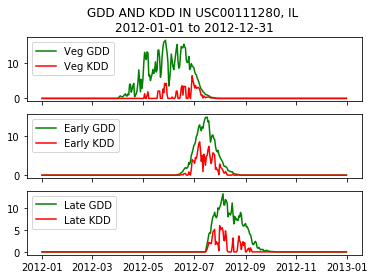

In [0]:
#Make function that plots phase-wise GDDs and KDDs. Function takes station name, start, and end date as a string
#Date format: yyyy-mm-dd

def plot_GDD_KDD(stat, start_date, end_date):
  df = combined_dict[stat]
  
  x = df.loc[start_date:end_date].index
  y1 = df.loc[start_date:end_date]['GDD_vegetative'].values
  y2 = df.loc[start_date:end_date]['KDD_vegetative'].values
  y3 = df.loc[start_date:end_date]['GDD_early_grain'].values  
  y4 = df.loc[start_date:end_date]['KDD_early_grain'].values
  y5 = df.loc[start_date:end_date]['GDD_late_grain'].values 
  y6 = df.loc[start_date:end_date]['KDD_late_grain'].values  


  f, axarr = plt.subplots(3, sharex=True)
  axarr[0].plot(x, y1, color = 'green', label = 'Veg GDD')
  axarr[0].plot(x, y2, color = 'red', label = 'Veg KDD')
  axarr[0].legend(loc = 'upper left')
  axarr[0].set_title('GDD AND KDD IN ' + stat + ', ' + 'IL \n' + start_date + ' to ' + end_date)

  axarr[1].plot(x, y3, color = 'green', label = 'Early GDD')
  axarr[1].plot(x, y4, color = 'red', label = 'Early KDD')
  axarr[1].legend(loc = 'upper left')

  axarr[2].plot(x, y5, color = 'green', label = 'Late GDD')
  axarr[2].plot(x, y6, color = 'red', label= 'Late KDD')
  axarr[2].legend(loc = 'upper left')

plot_GDD_KDD('USC00111280', '2012-01-01', '2012-12-31' )

In [0]:
#Find cumulative sum for phase wise GDD and KDD. Need new dictionary.

cum_sum_dict = {}

for i in combined_dict:
  #set variable name of each station to df for convenience
  df = combined_dict[i]
  
  #Drop unecessary variables
  df = df.drop(['TMAX', 'TMIN', 'TMAX_bound', 'TMIN_bound', 'GDD', 'KDD', 'vegetative', 'early_grain', 'late_grain'], axis = 1)
  
  #Make empty dateframe
  df_sum = pd.DataFrame()
  
  #Iterate through all years. Filter down to y, find cumulative sum, place values in dataframe. Values in series are in order from df columns.
  for y in df.index.year.unique():
    df_sorted = df[df.index.year == y]
    holder = df_sorted.sum(axis = 0)
    df_sum[y] = holder.values
    
  #Swap columns and rows. Fix index and name columns.
  df_sum = df_sum.transpose()
  df_sum = df_sum.reset_index()
  df_sum = df_sum.rename(index = str, columns = {'index':'year', 0:'GDD_vegetative', 1: 'GDD_early_grain', 2:'GDD_late_grain', 3:'KDD_vegetative', 4:'KDD_early_grain', 5:'KDD_late_grain'})

  cum_sum_dict[i] = df_sum
  

In [0]:
#save my dictionaries so far bc take a long time to generate

pickle.dump(cum_sum_dict, open('cum_sum_dict.p', 'wb'))
pickle.dump(combined_dict, open('combined_dict.p', 'wb'))

#Read dicts back in when ready! Cum_Sum is yearly summed GDDs/KDDs (no average removed). Combined_dict is raw TMAX TMIN
#cum_sum_dict = pickle.load(open('cum_sum_dict.p', 'rb'))
#combined_dict = pickle.load(open('combined_dict.p', 'rb'))


In [0]:
#Time to associate stations and counties
Grouped_IL_Counties = pd.read_csv('Grouped_IL_Counties.csv')
Grouped_IL_Counties.head()

,COUNTY_NAM,CO_FIPS,STATION_ID
0,MCHENRY,111,USC00118916
1,BOONE,7,USC00118916
2,OGLE,141,USC00118916
3,LASALLE,99,USC00118916
4,BUREAU,11,USC00118916


In [0]:
#Make new dictionary where keys are county names are keys and values are relevant stations from cum_sum_dict
county_info_dict = {}

for i in Grouped_IL_Counties.index:
  d = copy.deepcopy(Grouped_IL_Counties.loc[i])
  df = cum_sum_dict[d[2]]
  county_info_dict[d[0]] = df

#d[0] = county name
#d[1] = county fips
#d[2] = station ID

In [0]:
#Add the yield for each county. Make sure to join on dfs in county_info dict bc we removed some "bad years" from those that are still
#present in yield data

df_yield = pd.read_csv('yield.csv')

for i in county_info_dict:
  county_yield = df_yield[df_yield['county'] == i]
  county_yield = county_yield.drop(['state_fips', 'county_code'], axis = 1)
  
  df = pd.merge(county_yield, county_info_dict[i], on = 'year', how = 'left')


In [0]:
test = {}

for i in county_info_dict:
  years = county_info_dict[i]['year'].values
  df_county_yield = df_yield[df_yield['county'] == i]
  df_county_year_yield = df_county_yield[df_county_yield['year'].isin(years)]
  
  df = pd.merge(df_county_year_yield, county_info_dict[i], how = 'left', on = ['year'])
  
  test[i] = df                            

In [0]:
#Edited version of above cell

#Append yield to each county df. If county has no yield data, do not include it and save the county name
#Could not figure out how to update values in dictionary so had to make new dictionary

county_info_dict2 = {}
no_yield_counties = []

df_yield = pd.read_csv('yield.csv')

for i in county_info_dict:
  
  if df_yield[df_yield['county'] == i].empty:
    no_yield_counties.append(i)
    
  else:
    df_yield1 = df_yield[(df_yield['county'] == i) & (df_yield['year'] >= 1981) & (df_yield['state_fips'] == 17)]
    years = county_info_dict[i]['year'].values

    df_yield2 = df_yield1[df_yield1['year'].isin(years)]

    df = pd.merge(df_yield2, county_info_dict[i], how = 'left', on = ['year'])

    county_info_dict2[i] = df

In [0]:
#Remove mean values (within each county) from columns. 
#SOMETHING IS NOT MAKING SENSE, MOST RECENT YEARS HAVE NEGATIVE VALUES WHEN REMOVE THE MEAN

for i in county_info_dict2:
  for j in county_info_dict2[i]:
    if j in ['yield', 'state_fips', 'county', 'county_code']:
      continue
      
    elif j == 'year':
      county_info_dict2[i]['year_prime'] = county_info_dict2[i]['year'] - county_info_dict2[i]['year'].mean()
      
    else:
      county_info_dict2[i][j] = county_info_dict2[i][j] - county_info_dict2[i][j].mean()
      
    

In [0]:
# pickle.dump(county_info_dict2, open('county_info_dict2.p', 'wb'))
# pickle.dump(county_info_dict, open('county_info_dict.p', 'wb'))

#Dict has keys as station names, cumulative phase ise GDD/KDD
cum_sum_dict = pickle.load(open('cum_sum_dict.p', 'rb'))

#Dict has keys as station names. Has bounded TMAX, TMIN, not phase wise GDD/KDD, has progress data
combined_dict = pickle.load(open('combined_dict.p', 'rb'))

#Dict has keys as county names, cum sum of GDD/DD WITHOUT means removed, no yield data
county_info_dict = pickle.load(open('county_info_dict.p', 'rb'))

#Dict has keys as county names. Cumlative GDD/KDD WITH means removed. Has yield in each year.
county_info_dict2 = pickle.load(open('county_info_dict2.p', 'rb'))

Text(0, 0.5, 'GDD Late Grain')

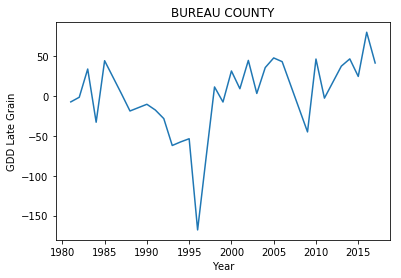

In [0]:
x = county_info_dict2['BUREAU']['year'].values
y = county_info_dict2['BUREAU']['GDD_late_grain'].values

plt.plot(x,y)
plt.title('BUREAU COUNTY')
plt.xlabel('Year')
plt.ylabel('GDD Late Grain')

In [0]:
#Function that visualizes linearity of variables

def visualize_linearity(df):
  y = df['yield']

  f = plt.figure(figsize = (20,10))
  ax = f.add_subplot(331)
  ax2 = f.add_subplot(334)
  ax3 = f.add_subplot(335)
  ax4 = f.add_subplot(336)
  ax5 = f.add_subplot(337)
  ax6 = f.add_subplot(338)
  ax7 = f.add_subplot(339)

  ax.scatter(df['year'], y)
  ax.set_xlabel('Year')
  ax.set_ylabel('Yield')
  ax.set_title('Year vs. Yield')

  ax2.scatter(df['GDD_vegetative'], y)
  ax2.set_xlabel('GDD')
  ax2.set_ylabel('Yield')
  ax2.set_title('GDD_Vegetative vs. Yield')

  ax3.scatter(df['GDD_early_grain'], y)
  ax3.set_xlabel('GDD')
  ax3.set_ylabel('Yield')
  ax3.set_title('GDD_early_grain vs. Yield')

  ax4.scatter(df['GDD_late_grain'], y)
  ax4.set_xlabel('GDD')
  ax4.set_ylabel('Yield')
  ax4.set_title('GDD_late_grain vs. Yield')

  ax5.scatter(df['KDD_vegetative'], y)
  ax5.set_xlabel('KDD')
  ax5.set_ylabel('Yield')
  ax5.set_title('KDD_vegetative vs. Yield')

  ax6.scatter(df['KDD_early_grain'], y)
  ax6.set_xlabel('KDD')
  ax6.set_ylabel('Yield')
  ax6.set_title('KDD_early_grain vs. Yield')

  ax7.scatter(df['KDD_late_grain'], y)
  ax7.set_xlabel('KDD')
  ax7.set_ylabel('Yield')
  ax7.set_title('KDD_late_grain vs. Yield')

  plt.tight_layout()
  

In [0]:
#Testing above function
visualize_linearity(county_info_dict2['ADAMS'])

In [0]:
#Need to add correlation coefs df for each county. Add as value to each key. Convert values to list format so can append other values later
#For reference: value 0 is GDD/KKD and yield data. Value 1 is correlation coefs.

for i in county_info_dict2:
  df = county_info_dict2[i].drop(['county','state_fips', 'county_code'], axis = 1).corr()
  county_info_dict2[i] = [county_info_dict2[i], df]

In [0]:
#Function to calculate least squares regression intercept and coefficients
#X and Y will be dataframes containing the independent and dependent variables respectivly

def least_squares_coef(X,Y):
  global output
  #Add column of ones to matrix X
  X.insert(0,'ones',1)
  X = X.values

  #Matrix X prime will be the transpose of matrix X
  X_prime = X.transpose()

  #Matrix Y is the dependent variable
  Y = Y.values

  #Calculate regression coefficients
  #b = (X'X)^-1 * X'Y

  W = np.linalg.inv(np.dot(X_prime, X))
  Z = np.dot(X_prime, Y)
  output = np.dot(W,Z)

In [0]:
#Remeber that this means you trained on ALL years. Should only train on first 20.

for i in county_info_dict2:
  print(i)
  X = county_info_dict2[i][0][['year_prime','GDD_vegetative','GDD_early_grain','GDD_late_grain','KDD_vegetative','KDD_early_grain','KDD_late_grain']].copy()
  Y = county_info_dict2[i][0][['yield']].copy()

  least_squares_coef(X,Y)

  county_info_dict2[i].append(np.array(output))

In [0]:
for i in county_info_dict2:
  print(i)
  
  X = county_info_dict2[i][0][['year_prime','GDD_vegetative','GDD_early_grain','GDD_late_grain','KDD_vegetative','KDD_early_grain','KDD_late_grain']].copy()
  Y = county_info_dict2[i][0][['yield']].copy()
  
  X_train = X[10:]
  Y_train = Y[10:]

  X_test = X[0:10]
  Y_test = Y[0:10]

  least_squares_coef(X_train,Y_train)
  
  Y_test['Predicted Yield'] = output[0,0] + output[1,0]*X_test['year_prime'] + output[2,0]*X_test['GDD_vegetative'] + output[3,0]*X_test['GDD_early_grain'] + output[4,0]*X_test['GDD_late_grain'] + output[5,0]*X_test['KDD_vegetative'] + output[6,0]*X_test['KDD_early_grain'] + output[7,0]*X_test['KDD_late_grain']
  
  Y_test['Year'] = county_info_dict2[i][0]['year']
  df_predictions = Y_test.set_index('Year')
  
  county_info_dict2[i].extend([np.array(output), df_predictions])
  

In [0]:
def plot_prediction(county):
  df = county_info_dict2[county][3]
  actual = df['yield']
  predicted = df['Predicted Yield']

  plt.scatter(actual, predicted)
  plt.plot([100,200], [100,200], 'k-', lw = 2)
  plt.xlabel('Observed Yield')
  plt.ylabel('Predicted Yield')
  plt.title('Predicted vs. Observed Yield in ' + county +' County, IL \n r^2 = ' + str(round((df['yield'].corr(df['Predicted Yield']))**2, 4)))
  plt.show()

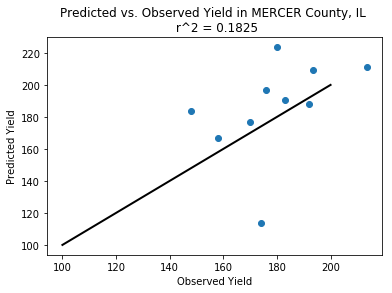

In [0]:
plot_prediction('MERCER')

In [0]:
pickle.dump(county_info_dict2, open('county_info_dict2.p', 'wb'))
pickle.dump(county_info_dict, open('county_info_dict.p', 'wb'))

NameError: ignored

In [0]:
#bug list
#Franklin county no longer exists in county info dict 1 or 2

['LASALLE', 'DUPAGE', 'DEKALB', 'DEWITT', 'ST. CLAIR']

In [0]:
variance = []

for i in county_info_dict2:
  df = county_info_dict2[i][3]
  variance.append((df['yield'].corr(df['Predicted Yield'])**2)*100)

Text(0.5, 1.0, 'Explained Variance in Observed Yield in IL Counties')

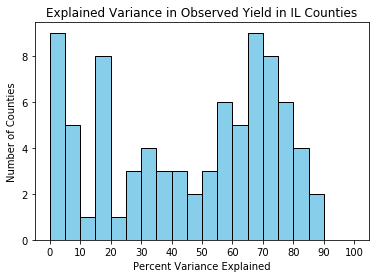

In [0]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,1)
ax.hist(variance, 20, range = [0, 100], color = 'skyblue', ec = 'black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_xlabel('Percent Variance Explained')
ax.set_ylabel('Number of Counties')
ax.set_title('Explained Variance in Observed Yield in IL Counties')


In [0]:
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

In [0]:
sum(variance)/len(variance)

45.673003775387556

In [0]:
#Investigate big changes in GDD and KDD from station USC00118147 and USC00111280

county_info_dict2['RANDOLPH'][0]

In [0]:
county_info_dict['RANDOLPH']

In [0]:
county_info_dict['RANDOLPH']

In [0]:
combined_dict['USC00118147'].loc['2008-12-31':'2011-05-29']

In [0]:
combined_dict['USC00118147'][combined_dict['USC00118147'].isnull().any(axis=1)].loc['2011-01-01':'2011-12-31']

In [0]:
interpolated_TMAX_dict = {}
bad_years_TMAX_dict = {}

  
#Pick out ith df. Make sure index is in datetime. Set date range. Make a copy of TMAX column in df
#temp_sample = copy.deepcopy(combined_dict['USC00118147'].loc['1981-01-01':'2017-12-31']) 
temp_sample = test
temp_TMAX = copy.deepcopy(temp_sample[['TMAX']])
temp_TMAX['TMAX'] = pd.to_numeric(temp_TMAX['TMAX'])

count = 0
flag = False
bad_years_TMAX = []

#idx is the row number starting at zero, t is the actual temperature value
for idx, t in enumerate(temp_TMAX.TMAX):
  if flag == False and ~np.isnan(t):
    continue

  elif flag == False and np.isnan(t):
    #Case where row 0 is nan. Make value of row 1 = row 2, then set start index to row 0
    if idx == 0:
      flag = False
      temp_TMAX.iloc[0] = temp_TMAX.iloc[1].values

    elif idx != 0:
      flag = True
      start_index = temp_TMAX.index[idx-1] #find index of point right before first nan
      count = count + 1

  elif flag == True and np.isnan(t):
    count = count + 1
#     if count > 7 and len(temp_TMAX)-1 == idx:
#       bad_years_TMAX.append(temp_TMAX.index[idx].year)
      if count > 7 and len(temp_TMAX)-1 == idx:
        bad_years_TMAX.append(temp_TMAX.index[idx].year)

  elif flag == True and ~np.isnan(t):
    flag == False
    end_index = temp_TMAX.index[idx]
    print('I was NaN and now not' + end_index)

    if count <= 7:
      interpolated = temp_TMAX[start_index:end_index].interpolate()
      temp_TMAX.update(interpolated) #update the uninterpolated data with the newly interpolated data


    elif count > 7:
      if end_index.year not in bad_years_TMAX:
        bad_years_TMAX.append(end_index.year)
        print('I am adding' + end_index)

        if start_index.year not in bad_years_TMAX: #in case missing data stretches between years
          bad_years_TMAX.append(start_index.year)

    count = 0

#add a years column
temp_TMAX['year'] = temp_TMAX.index.year  

#drop the rows in bad years
for b in bad_years_TMAX:
  temp_TMAX = temp_TMAX[temp_TMAX.index.year != b]

#drop the year column
temp_TMAX = temp_TMAX.drop(columns = ['year'])

# interpolated_TMAX_dict[i] = temp_TMAX
# bad_years_TMAX_dict[i] = bad_years_TMAX

In [0]:
count = 0
Flag = False
bad_years_TMAX = []

for idx, t in enumerate(temp_TMAX.TMAX):
  
  #No previous NaN detected, current point is not NaN
  if Flag == False and ~np.isnan(t):
    continue
  
  #No previous NaN detected, current point IS NaN
  elif Flag == False and np.isnan(t):
    
    #Is this the VERY FIRST data point of data set?
    if idx == 0:
      
      #Make df that contains only days with data.
      complete_days = temp_TMAX[temp_TMAX['TMAX'].notnull()]
      days_till_next_value = complete_days.index[0] - temp_TMAX.index[idx]
      days_till_next_value = days_till_next_value.value
      
      #If next complete datapoint is greater than 7 days away, add year of first data point to bad years
      if days_till_next_value > 7:
        bad_years_TMAX.append(temp_TMAX.index[idx].year)
      
      #If next complete datapoint is less than or equal to 7 days away, make first value equal to next complete one. Flag is still false.
      else:
        temp_TMAX.iloc[idx] = complete_days.iloc[0].values
        
    #Is this not the very first data point of data set?
    elif idx != 0:
      
      #Check if data point comes from a bad year. Skip point if so.
      if temp_TMAX.index[idx].year in bad_years_TMAX:
        continue
      
      #Check if point right before first nan is also nan. Would happen if entire year before was nan.
      #This is condition where everything prior to this point is nan
      elif math.isnan(temp_TMAX.TMAX.iloc[idx - 1]):
        complete_days = temp_TMAX[temp_TMAX['TMAX'].notnull()]
        
        #If the next day is not the first complete day keep skipping
        if temp_TMAX.index[idx + 1] != complete_days.index[0]:
          continue
        
        #If the next day is a complete day, check how many of next 8 days are missing.
        elif temp_TMAX.index[idx + 1] == complete_days.index[0]:
         
          num_missing_days_in_next_8 = temp_TMAX.TMAX.iloc[idx+1:idx+10].isnull().sum()
          
          if num_missing_days_in_next_8 <= 7:
            #Not sure about putting flag here
            start_index = temp_TMAX.index[idx + 1]
            
          if num_missing_days_in_next_8 > 7:
            #work here
          
          
      #Check if point right before first nan IS NOT A NAN. Typical case
      elif ~math.isnan(temp_TMAX.TMAX.iloc[idx - 1]):
        #Set index of previous value to start index. Add one to counter. Flag that nan has been detected.
        start_index = temp_TMAX.index[idx - 1]
        count = count + 1
        Flag = True
      

      ###########
      else:

        #First nan in series detected. Flip flag to T and start counter.
        Flag = True
        count = count + 1
        print('Hello!')

        #Note index of first nan value and index of where to start interpolating
        index_first_nan = temp_TMAX.index[idx]
        index_start_interpolate = temp_TMAX.index[idx-1] 
      
  #Previous NaN detected, current point IS NaN
  elif Flag == True and np.isnan(t):
    
    #Check if still in same year as first nan in series. NOT SURE WHERE TO CHECK IF MORE THAN 7 NANS IN A ROW
    if index_first_nan.year == temp_TMAX.index[idx].year:
      continue
    
    #Check if this data point is the very last point in entire data set
    if temp_TMAX.index[idx] == temp_TMAX.index[-1]:
      
      #Greater than 7 days of nans?
      if count > 7
    
    #Need conditions for if very last datapoint is NaN

      
        
        

      


Hello!


In [0]:
bad_years_TMAX = []

bad_years_TMAX.append(temp_TMAX.index[700].year)

temp_TMAX.index[0].year in bad_years_TMAX

False

In [0]:
complete_days = temp_TMAX[temp_TMAX['TMAX'].notnull()]
complete_days.index[0]
#temp_TMAX.index[0] - df.index[1]

Timestamp('2008-12-31 00:00:00', freq='D')

In [22]:
6 <= 8

True

In [0]:
 test = copy.deepcopy(combined_dict['USC00118147'].loc['2008-12-31':'2011-01-01'])

In [3]:
raw_temp_data = pickle.load(open('raw_temp_data.p', 'rb'))

UnpicklingError: ignored

In [0]:
temp_TMAX = copy.deepcopy(raw_temp_data['USC00118147'].loc['2008-12-31':'2011-01-01'])

In [0]:
raw_temp_data = pickle.load(open('raw_temp_data.p', 'rb'))

county_info_dict2 = pickle.load(open('county_info_dict2.p', 'rb'))

In [0]:
#DO NOT DELETE
#Code to put all of data into excel file. Just need to add columns for weather variance, trend variance, total variance.
#Also need to include above items in actula county_info_dict
#'Weather Variance', 'Trend Variance', 'Total Variance'])
df = pd.DataFrame(columns = ['County Name', 'Intercept', 'Year_coef', 'GDD_veg_coef', 'GDD_early_coef', 'GDD_late_coef', 'KDD_veg_coef', 'KDD_early_coef', 'KDD_late_coef'])

for i in county_info_dict2:
  row = []
  row.append(i)
  for j in county_info_dict2[i][2]:
    row.append(j[0])
  df.loc[0] = row